In [30]:
import pandas as pd
import os
import glob

# =========================
# FOLDER PATH
# =========================
input_folder = "fundamental_data"      # folder containing raw CSVs
output_folder = "clean_fundamental_data"

# Create output folder if not exists
os.makedirs(output_folder, exist_ok=True)

# =========================
# INDICATORS TO KEEP
# =========================
relevant_indicators = [
    "Net Sales/Income from operations",
    "Total Income From Operations",
    "Net Profit/(Loss) For the Period",
    "P/L Before Tax",
    "Interest",
    "Depreciation",
    "Basic EPS",
    "Equity Share Capital"
]


# =========================
# PROCESS ALL CSV FILES
# =========================
files = glob.glob(os.path.join(input_folder, "*.csv"))

for input_file in files:

    print("Processing:", input_file)

    df = pd.read_csv(input_file)

    # Clean column names
    df.columns = df.columns.str.strip()

    # Filter relevant rows
    filtered = df[df["Indicators"].isin(relevant_indicators)]

    #remove unnamed columns
    filtered = filtered.loc[:, ~filtered.columns.str.contains('Unnamed')]

    # Transpose
    filtered.set_index("Indicators", inplace=True)
    clean_df = filtered.T

    # Reset index
    clean_df.reset_index(inplace=True)
    clean_df.rename(columns={"index": "Quarter"}, inplace=True)

    #remove unnamed columns
    clean_df = clean_df.loc[:, ~clean_df.columns.str.contains('Unnamed')]

    # =========================
    # OUTPUT FILE NAME
    # =========================
    filename = os.path.basename(input_file)
    output_file = os.path.join(output_folder, filename.replace(".csv", "_clean.csv"))

    clean_df.to_csv(output_file, index=False)

    print("✅ Saved:", output_file)

print("\n🎉 All files processed successfully!")


Processing: fundamental_data\bhartiairtel.csv
✅ Saved: clean_fundamental_data\bhartiairtel_clean.csv
Processing: fundamental_data\hdfc_fundamentals.csv
✅ Saved: clean_fundamental_data\hdfc_fundamentals_clean.csv
Processing: fundamental_data\hul_fundamentals.csv
✅ Saved: clean_fundamental_data\hul_fundamentals_clean.csv
Processing: fundamental_data\infy_fuindamentals.csv
✅ Saved: clean_fundamental_data\infy_fuindamentals_clean.csv
Processing: fundamental_data\mm_fundamentals.csv
✅ Saved: clean_fundamental_data\mm_fundamentals_clean.csv
Processing: fundamental_data\reliance_fundamentals.csv
✅ Saved: clean_fundamental_data\reliance_fundamentals_clean.csv

🎉 All files processed successfully!


In [25]:
import yfinance as yf
import pandas as pd
import os

# =========================
# STOCK LIST
# =========================
stocks = {
    "RELIANCE": "RELIANCE.NS",
    "HDFCBANK": "HDFCBANK.NS",
    "INFY": "INFY.NS",
    "M&M": "M&M.NS",
    "BHARTIARTL": "BHARTIARTL.NS",
    "HUL": "HINDUNILVR.NS"
}

start_date = "2020-01-01"
end_date = "2026-01-01"

os.makedirs("market_data/train", exist_ok=True)
os.makedirs("market_data/test", exist_ok=True)

# =========================
# LOOP THROUGH STOCKS
# =========================
for name, ticker in stocks.items():

    print(f"\nDownloading {name}...")

    data = yf.download(
        ticker,
        start=start_date,
        end=end_date,
        auto_adjust=False
    )

    data.reset_index(inplace=True)

    # Split
    train = data[data["Date"] < "2025-10-01"]
    test = data[data["Date"] >= "2025-10-01"]

    # Save
    train.to_csv(f"market_data/train/{name}_train.csv", index=False)
    test.to_csv(f"market_data/test/{name}_test.csv", index=False)

    print(f"✅ Saved {name}")

print("\n🎉 All market data downloaded!")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


✅ Saved RELIANCE

✅ Saved HDFCBANK




[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

✅ Saved INFY

✅ Saved M&M

✅ Saved BHARTIARTL

✅ Saved HUL

🎉 All market data downloaded!


,date,adj close,close,high,low,open,volume
0,2020-01-01,605.529296875,639.299988,640.0,635.2999877929688,638.0499877929688,3673698
1,2020-01-02,609.3890991210938,643.375000,644.0,639.5,639.5,6137166
2,2020-01-03,600.6987915039062,634.200012,642.5,631.7999877929688,641.0999755859375,10855550
3,2020-01-06,587.6987915039062,620.474976,630.9000244140625,618.0,630.0,10890186
4,2020-01-07,597.0048217773438,630.299988,635.7249755859375,626.125,629.4500122070312,14724494


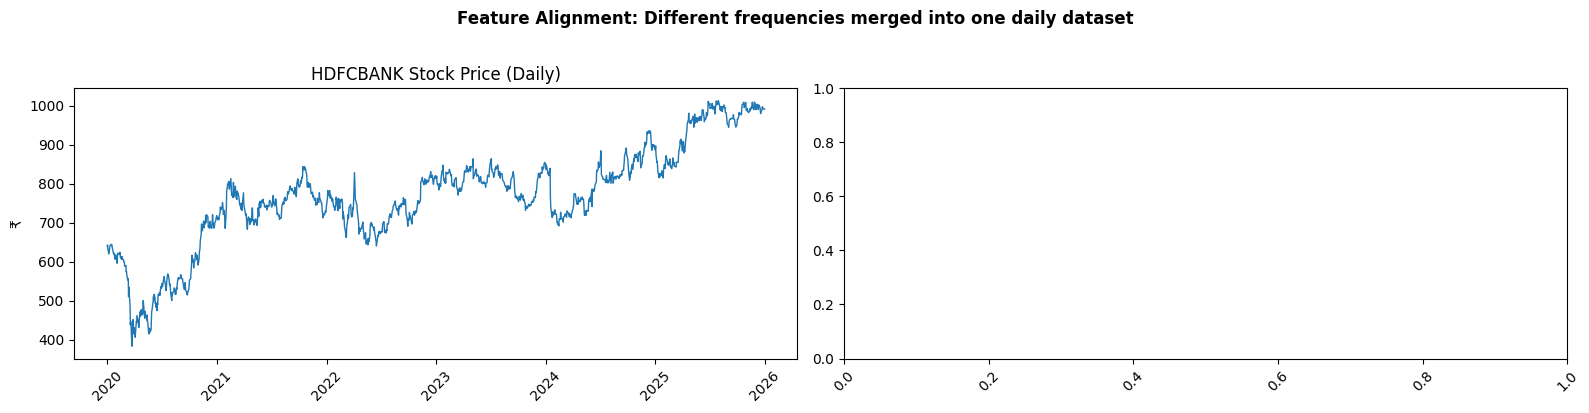

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

# ============================================================
# 1. LOAD AND PREPARE DATA
# ============================================================
name = "HDFCBANK"

train_path = f"market_data/train/{name}_train.csv"
test_path = f"market_data/test/{name}_test.csv"

if os.path.exists(train_path) and os.path.exists(test_path):
    df_train = pd.read_csv(train_path)
    df_test = pd.read_csv(test_path)
    df = pd.concat([df_train, df_test], ignore_index=True)
else:
    print("Files not found! Please run your download script first.")
    raise SystemExit

# ------------------------------------------------------------
# CLEANING
# ------------------------------------------------------------

# Make column names lowercase
df.columns = [c.lower() for c in df.columns]

# Remove accidental ticker rows
df = df[df['close'] != 'HDFCBANK.NS']

# Convert date column
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Convert price column to numeric
df['close'] = pd.to_numeric(df['close'], errors='coerce')

# Drop bad rows
df = df.dropna(subset=['date', 'close'])

# VERY IMPORTANT: sort by date
df = df.sort_values('date')

# Reset index (optional but clean)
df = df.reset_index(drop=True)

display(df.head())

# ============================================================
# 2. PLOTTING
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# Main stock price plot
axes[0].plot(df['date'], df['close'], linewidth=1)
axes[0].set_title('HDFCBANK Stock Price (Daily)')
axes[0].set_ylabel('₹')

# Nice date formatting
axes[0].xaxis.set_major_locator(mdates.YearLocator())
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Rotate ticks
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

plt.suptitle(
    'Feature Alignment: Different frequencies merged into one daily dataset',
    fontsize=12,
    fontweight='bold',
    y=1.02
)

plt.tight_layout()
plt.show()


In [29]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

start = "2020-01-01"
end   = "2025-12-31"

usd_inr = yf.download("INR=X", start=start, end=end, auto_adjust=True)
display(usd_inr.head())

usd_inr = usd_inr[['Close']]
usd_inr.columns = ['USDINR']

# Convert to log returns (stationarity)
usd_inr['USDINR_ret'] = np.log(usd_inr['USDINR']).diff()

usd_inr = usd_inr[['USDINR_ret','USD_INR','Date']]
display(usd_inr.head())

india_10y = pd.read_csv("macro_data\India 10-Year Bond Yield Historical Data.csv")
display(india_10y.head())

rbi_macro_data = pd.read_csv(r"macro_data\rbi_macro_indicators.csv")
display(rbi_macro_data.head())

crude = yf.download("BZ=F", start=start, end=end)
display(crude.head())
crude = crude[['Close']]

#plot crude price
plt.figure(figsize=(10, 4))
plt.plot(crude.index, crude['Close'], label='Crude Oil Price (BZ=F)', color='orange')
plt.title('Crude Oil Price (BZ=F) from 2020 to 2025')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()


crude.columns = ['CRUDE']

crude['CRUDE_ret'] = np.log(crude['CRUDE']).diff()

crude = crude[['CRUDE_ret']]


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,INR=X,INR=X,INR=X,INR=X,INR=X
Date,,,,,
2020-01-01,71.275803,71.430000,71.029999,71.275803,0
2020-01-02,71.025002,71.405502,71.025002,71.025002,0
2020-01-03,71.415001,71.995003,71.229797,71.415001,0
2020-01-06,71.731003,72.190002,71.703003,71.720001,0
2020-01-07,71.787003,72.032600,71.668999,72.019997,0


KeyError: "['USD_INR', 'Date'] not in index"

In [ ]:
# =========================================================
# PROFESSIONAL NEWS PIPELINE (STOCK + MACRO)
# 6-MONTH BATCHING + STORAGE
# =========================================================


from serpapi import GoogleSearch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch
import datetime
import os

# =========================================================
# CONFIG
# =========================================================

API_KEY = ""

STOCKS = ["RELIANCE", "HDFCBANK", "INFY", "M&M", "BHARTIARTL", "HUL"]

MACRO_QUERY = "India economy OR RBI OR inflation OR crude OR tariff OR interest rates"

START_YEAR = 2020
END_YEAR   = 2025

BASE_DIR = "news_data"
os.makedirs(BASE_DIR, exist_ok=True)

# =========================================================
# LOAD FINBERT
# =========================================================

print("Loading FinBERT...")
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
model.eval()
print("FinBERT Loaded\n")

def finbert_score(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    return probs[0][0].item() - probs[0][1].item()

# =========================================================
# FETCH FUNCTION (WITH DATE FILTERING)
# =========================================================

def fetch_news(query, start_date, end_date):
    
    full_query = f"{query} after:{start_date} before:{end_date}"
    
    params = {
        "engine": "google_news",
        "q": full_query,
        "api_key": API_KEY,
        "hl": "en",
        "gl": "in"
    }
    
    search = GoogleSearch(params)
    results = search.get_dict()
    
    articles = []
    
    for item in results.get("news_results", []):
        articles.append({
            "date": item.get("date"),
            "headline": item.get("title"),
            "source": item.get("source", {}).get("name")
        })
    
    return pd.DataFrame(articles)

# =========================================================
# DATE PARSER
# =========================================================

from datetime import datetime, timedelta

def parse_google_date(date_str):
    if pd.isna(date_str):
        return None
    date_str = str(date_str).lower()
    now = datetime.now()
    
    try:
        if "hour" in date_str:
            return now - timedelta(hours=int(date_str.split()[0]))
        elif "day" in date_str:
            return now - timedelta(days=int(date_str.split()[0]))
        elif "week" in date_str:
            return now - timedelta(weeks=int(date_str.split()[0]))
        elif "month" in date_str:
            return now - timedelta(days=30*int(date_str.split()[0]))
        else:
            return pd.to_datetime(date_str)
    except:
        return None

# =========================================================
# MAIN COLLECTION LOOP
# =========================================================

def collect_news(label, query):

    print(f"\nCollecting: {label}")
    
    all_data = []
    
    for year in range(START_YEAR, END_YEAR + 1):
        
        periods = [
            (f"{year}-01-01", f"{year}-07-01"),
            (f"{year}-07-01", f"{year+1}-01-01")
        ]
        
        for start, end in periods:
            
            print(f"{label} | {start} → {end}")
            
            df = fetch_news(query, start, end)
            
            if df.empty:
                continue
            
            all_data.append(df)
    
    if not all_data:
        print("No data found.")
        return
    
    combined = pd.concat(all_data)
    display(combined.head(20))
    
    # Clean dates
    # Clean and standardize date strings
    combined["date"] = (
        combined["date"]
        .str.replace(" UTC", "", regex=False)
        .str.replace(",", "", regex=False)
    )

    combined["date"] = pd.to_datetime(
        combined["date"],
        format="%m/%d/%Y %I:%M %p %z",
        errors="coerce"
    )

    combined = combined.dropna(subset=["date"])

    print("After datetime conversion:", len(combined))
    print(combined.head())
    
    print(f"Total usable articles: {len(combined)}")
    
    # Sentiment scoring
    tqdm.pandas()
    combined["sentiment"] = combined["headline"].progress_apply(finbert_score)
    
    # Save raw + scored
    combined.to_csv(f"{BASE_DIR}/{label}_full_news.csv", index=False)
    
    # Daily aggregation
    daily = (
        combined
        .groupby(combined["date"].dt.date)["sentiment"]
        .mean()
        .to_frame(name=f"{label}_sentiment")
    )
    
    daily.index = pd.to_datetime(daily.index)
    daily = daily.shift(1)
    
    daily.to_csv(f"{BASE_DIR}/{label}_daily_sentiment.csv")
    
    print(f"{label} saved successfully\n")

# =========================================================
# RUN FOR STOCKS
# =========================================================

for stock in STOCKS:
    collect_news(stock, f"{stock} stock India")

# =========================================================
# RUN FOR MACRO NEWS
# =========================================================

collect_news("MACRO", MACRO_QUERY)

print("\nALL NEWS COLLECTION COMPLETE ✅")


Loading FinBERT...
FinBERT Loaded


Collecting: RELIANCE
RELIANCE | 2020-01-01 → 2020-07-01
RELIANCE | 2020-07-01 → 2021-01-01
RELIANCE | 2021-01-01 → 2021-07-01
RELIANCE | 2021-07-01 → 2022-01-01
RELIANCE | 2022-01-01 → 2022-07-01
RELIANCE | 2022-07-01 → 2023-01-01
RELIANCE | 2023-01-01 → 2023-07-01
RELIANCE | 2023-07-01 → 2024-01-01
RELIANCE | 2024-01-01 → 2024-07-01
RELIANCE | 2024-07-01 → 2025-01-01
RELIANCE | 2025-01-01 → 2025-07-01
RELIANCE | 2025-07-01 → 2026-01-01


,date,headline,source
0,"05/16/2020, 07:00 AM, +0000 UTC",'New Reliance for a New India',The Times of India
1,"06/24/2020, 07:00 AM, +0000 UTC",How a Change in a Rule by SEBI Helped Reliance...,newsclick.in
2,"06/01/2020, 07:00 AM, +0000 UTC",India’s Most Valuable Brands 2020: Reliance In...,Moneycontrol
3,"04/26/2020, 07:00 AM, +0000 UTC",Ambani Tests WhatsApp-Backed Online Store in L...,Bloomberg
4,"05/16/2020, 07:00 AM, +0000 UTC",Rights issue of Mukesh Ambani’s Reliance Indus...,The Hindu
5,"06/19/2020, 07:00 AM, +0000 UTC",Reliance Industries becomes India's first firm...,Mint
6,"06/20/2020, 07:00 AM, +0000 UTC",11 deals for $15 billion in 10 weeks: Why Indi...,Fortune
7,"06/05/2020, 07:00 AM, +0000 UTC",Ambani reshapes Reliance for digital India wit...,Nikkei Asia
8,"06/02/2020, 07:00 AM, +0000 UTC",RIL's mega right issue world's biggest by a no...,The Economic Times
9,"04/21/2020, 07:00 AM, +0000 UTC",Facebook invests $5.7 billion in Jio Platforms...,CNBC


After datetime conversion: 698
                       date  \
0 2020-05-16 07:00:00+00:00   
1 2020-06-24 07:00:00+00:00   
2 2020-06-01 07:00:00+00:00   
3 2020-04-26 07:00:00+00:00   
4 2020-05-16 07:00:00+00:00   

                                            headline              source  
0                     'New Reliance for a New India'  The Times of India  
1  How a Change in a Rule by SEBI Helped Reliance...        newsclick.in  
2  India’s Most Valuable Brands 2020: Reliance In...        Moneycontrol  
3  Ambani Tests WhatsApp-Backed Online Store in L...           Bloomberg  
4  Rights issue of Mukesh Ambani’s Reliance Indus...           The Hindu  
Total usable articles: 698


100%|██████████| 698/698 [00:32<00:00, 21.53it/s]


RELIANCE saved successfully


Collecting: HDFCBANK
HDFCBANK | 2020-01-01 → 2020-07-01
HDFCBANK | 2020-07-01 → 2021-01-01
HDFCBANK | 2021-01-01 → 2021-07-01
HDFCBANK | 2021-07-01 → 2022-01-01
HDFCBANK | 2022-01-01 → 2022-07-01
HDFCBANK | 2022-07-01 → 2023-01-01
HDFCBANK | 2023-01-01 → 2023-07-01


KeyboardInterrupt: 

In [27]:
#RELIANCE merging data
import pandas as pd
import os
reliance_stock_train = pd.read_csv("market_data/train/RELIANCE_train.csv")
reliance_stock_test = pd.read_csv("market_data/test/RELIANCE_test.csv")

#mergeing
reliance_stock = pd.concat([reliance_stock_train, reliance_stock_test], ignore_index=True)
#delete first row 
reliance_stock = reliance_stock[reliance_stock['Close'] != 'RELIANCE.NS']
#convert date to datetime
reliance_stock['Date'] = pd.to_datetime(reliance_stock['Date'], errors='coerce')
#convert Close, adjusted close to numeric
reliance_stock['Close'] = pd.to_numeric(reliance_stock['Close'], errors='coerce')
reliance_stock['Adj Close'] = pd.to_numeric(reliance_stock['Adj Close'], errors='coerce')

display(reliance_stock.head())
# display(reliance_stock.tail())

reliance_fundamentals = pd.read_csv("clean_fundamental_data/reliance_fundamentals_clean.csv")
#add price/eps column
#merge fundamentals with stock data on date

#copy fundamentals data based on date Dec'19 will be used for all dates from Jan'20 to Mar'20, Mar'20 data will be used for Apr'20 to Jun'20 and so on

#parse dates like Dec'19 to datetime, separate month and year from ' and then convert to datetime
#go through each row in Quarter and parse using custom parser

def parse_quarter_date(quarter_str):
    month_str, year_str = quarter_str.split("'")
    month_str = month_str.strip()
    year_str = year_str.strip()
    
    month_map = {
        "Jan": 1,
        "Feb": 2,
        "Mar": 3,
        "Apr": 4,
        "May": 5,
        "Jun": 6,
        "Jul": 7,
        "Aug": 8,
        "Sep": 9,
        "Oct": 10,
        "Nov": 11,
        "Dec": 12
    }
    
    month = month_map.get(month_str, None)
    year = int(year_str) + 2000
    
    if month is not None:
        #if month has 30 days return last day of month else return 31st
        #temp fix cuz need only 4 months end dates
        if month in [4, 6, 9, 11]:
            return pd.Timestamp(year=year, month=month, day=30)
        return pd.Timestamp(year=year, month=month, day=31)
    else:
        return pd.NaT

reliance_fundamentals['QuarterDate'] = reliance_fundamentals['Quarter'].apply(parse_quarter_date)

reliance_fundamentals = reliance_fundamentals.sort_values('QuarterDate').reset_index(drop=True)



final_reliance_data = pd.DataFrame()
for i in range(len(reliance_fundamentals)):
    quarter_date = reliance_fundamentals.loc[i, 'QuarterDate']
    if i < len(reliance_fundamentals) - 1:
        next_quarter_date = reliance_fundamentals.loc[i+1, 'QuarterDate']
    else:
        next_quarter_date = reliance_stock['Date'].max()  # Default end date
    
    mask = (reliance_stock['Date'] > quarter_date) & (reliance_stock['Date'] <= next_quarter_date)
    temp_stock_data = reliance_stock[mask].copy()
    
    for col in reliance_fundamentals.columns:
        if col != 'Quarter':
            temp_stock_data[col] = reliance_fundamentals.loc[i, col]
    
    final_reliance_data = pd.concat([final_reliance_data, temp_stock_data], ignore_index=True)

display(reliance_fundamentals.head())
#create P/EPS column
final_reliance_data['P/EPS'] = final_reliance_data['Adj Close'] / final_reliance_data['Basic EPS']

display(final_reliance_data.head(90))
display(final_reliance_data.tail())

os.makedirs("final_datasets", exist_ok=True)
final_reliance_data.to_csv("final_datasets/reliance_final.csv", index=False)


,Date,Adj Close,Close,High,Low,Open,Volume
1,2020-01-01,675.324219,690.138306,698.1387329101562,688.2639770507812,693.978515625,14004468
2,2020-01-02,686.821228,701.887512,704.4705200195312,691.2355346679688,691.2355346679688,17710316
3,2020-01-03,687.648804,702.733276,704.79052734375,696.2643432617188,700.8359985351562,20984698
4,2020-01-06,671.700684,686.435303,698.5044555664062,684.835205078125,694.8928833007812,24519177
5,2020-01-07,682.034546,696.995850,701.5217895507812,691.9212646484375,694.4356689453125,16683622


,Quarter,Net Sales/Income from operations,Total Income From Operations,Depreciation,Interest,P/L Before Tax,Net Profit/(Loss) For the Period,Equity Share Capital,Basic EPS,QuarterDate
0,Dec '19,"1,53,179","1,53,179","5,545","5,404","14,905","11,784","6,339",18.36,2019-12-31
1,Mar '20,"1,36,240","1,36,240","6,332","6,064","9,252","6,575","6,339",16.75,2020-03-31
2,Jun '20,"88,253","88,253","6,308","6,735","13,186","12,926","6,445",12.92,2020-06-30
3,Sep '20,"1,16,195","1,16,195","6,626","6,084","10,484","10,497","6,445",14.84,2020-09-30
4,Dec '20,"1,17,860","1,17,860","6,665","4,326","14,907","14,819","6,445",20.33,2020-12-31


,Date,Adj Close,Close,High,Low,Open,Volume,Net Sales/Income from operations,Total Income From Operations,Depreciation,Interest,P/L Before Tax,Net Profit/(Loss) For the Period,Equity Share Capital,Basic EPS,QuarterDate,P/EPS
0,2020-01-01,675.324219,690.138306,698.1387329101562,688.2639770507812,693.978515625,14004468,"1,53,179","1,53,179","5,545","5,404","14,905","11,784","6,339",18.36,2019-12-31,36.782365
1,2020-01-02,686.821228,701.887512,704.4705200195312,691.2355346679688,691.2355346679688,17710316,"1,53,179","1,53,179","5,545","5,404","14,905","11,784","6,339",18.36,2019-12-31,37.408564
2,2020-01-03,687.648804,702.733276,704.79052734375,696.2643432617188,700.8359985351562,20984698,"1,53,179","1,53,179","5,545","5,404","14,905","11,784","6,339",18.36,2019-12-31,37.453639
3,2020-01-06,671.700684,686.435303,698.5044555664062,684.835205078125,694.8928833007812,24519177,"1,53,179","1,53,179","5,545","5,404","14,905","11,784","6,339",18.36,2019-12-31,36.585005
4,2020-01-07,682.034546,696.995850,701.5217895507812,691.9212646484375,694.4356689453125,16683622,"1,53,179","1,53,179","5,545","5,404","14,905","11,784","6,339",18.36,2019-12-31,37.147851
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2020-05-08,698.676147,714.002441,722.277099609375,702.7103881835938,706.322021484375,84262770,"1,36,240","1,36,240","6,332","6,064","9,252","6,575","6,339",16.75,2020-03-31,41.712009
86,2020-05-11,705.386414,720.859924,738.3236694335938,718.8026733398438,722.3228149414062,67085063,"1,36,240","1,36,240","6,332","6,064","9,252","6,575","6,339",16.75,2020-03-31,42.112622
87,2020-05-12,661.747070,676.263306,716.9968872070312,669.7487182617188,715.3739013671875,100683202,"1,36,240","1,36,240","6,332","6,064","9,252","6,575","6,339",16.75,2020-03-31,39.507288
88,2020-05-13,675.787231,690.611450,704.7102661132812,671.020751953125,704.7102661132812,66430125,"1,36,240","1,36,240","6,332","6,064","9,252","6,575","6,339",16.75,2020-03-31,40.345506


,Date,Adj Close,Close,High,Low,Open,Volume,Net Sales/Income from operations,Total Income From Operations,Depreciation,Interest,P/L Before Tax,Net Profit/(Loss) For the Period,Equity Share Capital,Basic EPS,QuarterDate,P/EPS
1482,2025-12-24,1558.199951,1558.199951,1575.699951171875,1553.5999755859375,1572.699951171875,8815745,"2,54,623","2,54,623","14,416","6,827","29,124","22,146","13,532",13.42,2025-09-30,116.110280
1483,2025-12-26,1559.199951,1559.199951,1561.0,1554.300048828125,1554.699951171875,2311495,"2,54,623","2,54,623","14,416","6,827","29,124","22,146","13,532",13.42,2025-09-30,116.184795
1484,2025-12-29,1545.599976,1545.599976,1558.0999755859375,1543.5999755859375,1554.9000244140625,5972105,"2,54,623","2,54,623","14,416","6,827","29,124","22,146","13,532",13.42,2025-09-30,115.171384
1485,2025-12-30,1539.800049,1539.800049,1553.5999755859375,1537.800048828125,1547.0,8815884,"2,54,623","2,54,623","14,416","6,827","29,124","22,146","13,532",13.42,2025-09-30,114.739199
1486,2025-12-31,1570.400024,1570.400024,1577.0,1541.0,1541.0,5771830,"2,54,623","2,54,623","14,416","6,827","29,124","22,146","13,532",13.42,2025-09-30,117.019376
